In [1]:
import os
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('../')

In [3]:
selected_data = pd.read_csv('data/processed/data.csv')

In [4]:
X, y = selected_data.drop('Ilg', axis=1), selected_data['Ilg']

In [5]:
reg = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('estimator', RandomForestRegressor())
])

In [6]:
params = {
    'scaler': [StandardScaler(), MinMaxScaler()],
    'estimator__n_estimators': [10, 50, 100, 200],
    'estimator__max_features': ['auto', 'sqrt', 'log2'],
    'estimator__max_depth': [None, 10, 20, 30, 40, 50],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__bootstrap': [True, False],
    'estimator__criterion': ['poisson', 'squared_error', 'friedman_mse', 'absolute_error'],
    'estimator__random_state': [42]
}

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
17280 fits failed out of a total of 51840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
17280 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py

Best score:  922.9897716944523
Best params:  {'estimator__bootstrap': True, 'estimator__criterion': 'poisson', 'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 10, 'estimator__random_state': 42, 'scaler': StandardScaler()}


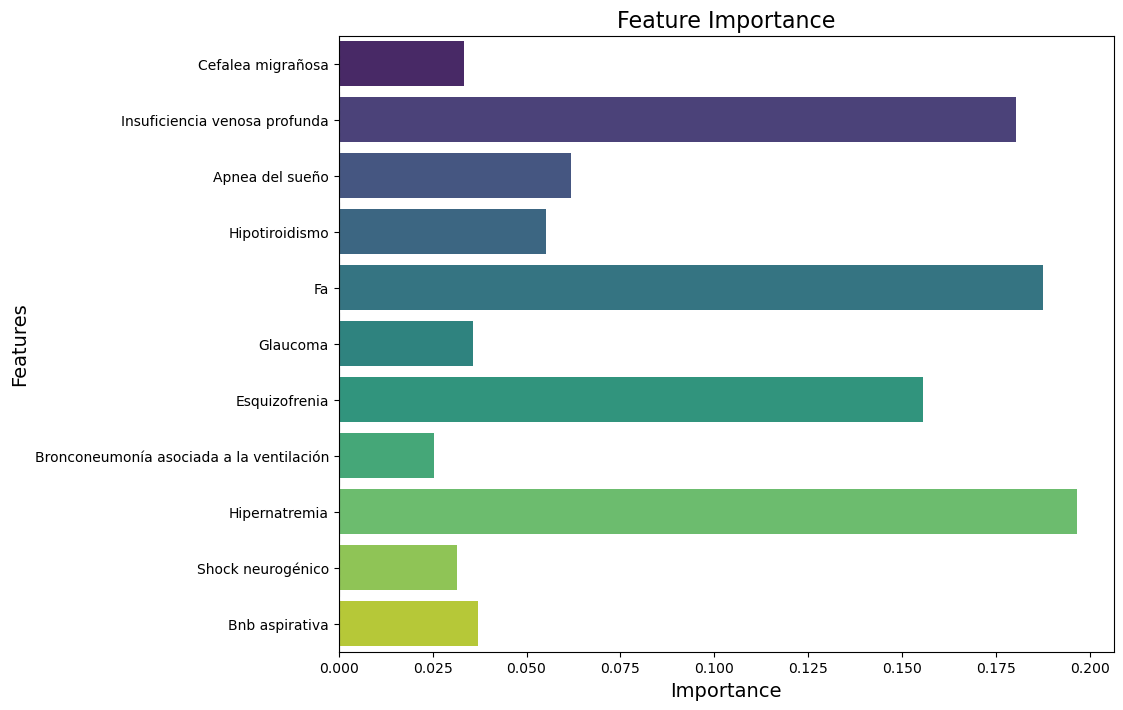

In [7]:
with mlflow.start_run():
    
    grid = GridSearchCV(estimator=reg, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid.fit(X, y)

    mlflow.log_param('model_type', 'regression')
    for param, value in grid.best_params_.items():
        mlflow.log_param(param, value)
    
    mlflow.log_metric("best_score", np.sqrt(-grid.best_score_))
    mlflow.sklearn.log_model(grid.best_estimator_, 'RandomForestRegressor')

    print('Best score: ', np.sqrt(-grid.best_score_))
    print('Best params: ', grid.best_params_)

    feature_importance = grid.best_estimator_.named_steps['estimator'].feature_importances_

    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importance, y=X.columns, palette='viridis') 
    plt.title('Feature Importance', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.axvline(0, color='grey', linestyle='--')

    mlflow.log_figure(plt.gcf(), 'feature_importance.png')
    plt.show()